# Searchflow

### Packages needed to run this notebook
- libmagic: ```brew install libmagic```

### ChromaDB
Don't forget to start the ChromaDB server: ```docker run -p 8000:8000 chromadb/chroma```

### Run the API
https://docs.astral.sh/uv/guides/integration/fastapi/

For development purposes, you can run the API with: ```uv run fastapi dev```

In [1]:
# Load packages from the src directory
import sys
import json
from vectrix_graphs import ExtractDocuments, setup_logger, ExtractMetaData
sys.path.append('../src')

from dotenv import load_dotenv
load_dotenv()

2024-10-25 22:30:54,912 - VectorDB - WARNING - Demo collection already exists


### Extracting chunks of data from a document

In [2]:
# Create chunks of data from a document
extract = ExtractDocuments(
    logger=setup_logger(name="Files", level="INFO"),
    )

result = extract.extract(file_path="files/arabic_test.docx", )

2024-10-25 22:30:55,062 - Files - INFO - Extracting documents from files/arabic_test.docx


In [3]:
print('Metadata:')
print(json.dumps(result[1].metadata, indent=4))

print('Content:')
print(result[1].page_content)

Metadata:
{
    "file_directory": "files",
    "filename": "arabic_test.docx",
    "last_modified": "2024-10-25T10:09:47",
    "orig_elements": "eJzlWMuO2zYU/RXBqwQoB3w//AcBgq5m1xQGn6mA8UzgUYsEQf+9lEjDV6aV0Sza2NMNIZCX5OW557702/dNfIj7+Djs+rDZdhtmKaPUWoQTMYgH5ZA1lCIsXTCGSa6d2PzSbfZxsMEONu/5vvF2iJ+fDt92IX4Z/shTOEuk/iHuQn+IfshL49njzPOmLj3afRwn7cG63u+G+DzchSf/dVx/sM/Dbv8U+tTHSSuKKUcEIyruCd5is+Vq83cWHOLXYVz/9CeWVI0j59MoppkwjXaa0dNoT5LUjlcN375Matz3w0MczzwHJDFBmY4J+ehIBkRTpF1SyEurRIzWMMxuABA5jkyBedqdcIGiBa8qClDjFOL1sX8ePgxxfwmyYLAkzgvkAhGI0wyecdIjrYSJMjlPPb5SyApv/IQAAVyB37YDMBmAsQW4lmWaALoFS941gLPTMrz0eFLLa3V+KTVLogmc6ovoWjPS4C1LJCDrmM1mTNmMWkjEvWfeY4OVNi+bkfwMMzIIOEDGbW/cdh3wSgn52TUvKrIMKqsXbmKz+9byI4c/zFnmB2Ym8wOrhBzDFmkRSeCaGivIlfLDARzkeWJ4IyypiheWJDBVdnDRndYZL4es4kcHFiA4+lz/mnnVKx65lnteJ8+Uzmk4hyLEheA5SlGBvOHYG5IU5/wGuMebmTfLvfoiedrNJVjg9HRUuXVONJiAS3pulSr1HmNAFFQ3NW/XkwoqtuFykS1CrCpYEYT3CaA5iMNs/vyyQwBNgMVo621z3db6gqU65+nsBtkfAuLOEqSDDyg6FgSjjCdlr9MXZlbV50Z4u74A4+lRm+7cC45MbF/hz0m7qNoMTgG

In [4]:
# Add additional metadata using a NER-pipeline
ner = ExtractMetaData(
    logger=setup_logger(name="ExtractMetaData", level="INFO",),
    model="llama3.1-70B" # Options are gpt-4o-mini, llama3.1-8B , llama3.1-70B
    )
result_with_metadata = ner.extract(result, source="uploaded_file")

2024-10-25 22:30:58,139 - ExtractMetaData - INFO - Extracting metadata from 9 documents, using llama3.1-70B


In [5]:
result_with_metadata[0].metadata

{'filename': 'arabic_test.docx',
 'filetype': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document',
 'author': '',
 'source': 'uploaded_file',
 'word_count': 41,
 'language': 'AR',
 'content_type': 'other',
 'tags': "['تداول', 'السوق المالية السعودية']",
 'summary': 'إجراءات تعليق تداول الأوراق المالية المدرجة وفقاً لقواعد الإدراج',
 'read_time': 0.205,
 'last_modified': '2024-10-25T10:09:47'}

### Adding the documents to a vector database (Chroma)

For this demo, the vector database will be saved locally on disk, restarting the container will delete the database.
I prefer using the cosine distance instead of the default squared L2 distance, we pass this using the `hnsw:space` metadata.

$$
d = 1.0 - \frac{\sum(A_i \times B_i)}{\sqrt{\sum(A_i^2) \cdot \sum(B_i^2)}}
$$

We use Ollama to calculate the embeddings locally with BGE-M3, since over a 100 langues are supported this is ideal for embedding Arabic documents.

BGE-M3 is based on the XLM-RoBERTa architecture and is distinguished for its versatility in Multi-Functionality, Multi-Linguality, and Multi-Granularity:

- Multi-Functionality: It can simultaneously perform the three common retrieval functionalities of embedding model: dense retrieval, multi-vector retrieval, and sparse retrieval.
- Multi-Linguality: It can support more than 100 working languages.
- Multi-Granularity: It is able to process inputs of different granularities, spanning from short sentences to long documents of up to 8192 tokens.

> ℹ️ So all embeddings will be calculated locally ℹ️


In [6]:
from vectrix_graphs import vectordb

vectordb.remove_collection("demo")
vectordb.create_collection("demo")

In [7]:
vectordb.add_documents(result_with_metadata)

In [8]:
# Now let's query the vector database
vectordb.similarity_search(
    query=" ماهي إجراءات تعليق تداول الأوراق المالية المدرجة عند عدم نشر المصدر معلوماته المالية الدورية؟",
    k=3
    )

[Document(metadata={'author': '', 'content_type': 'other', 'filename': 'arabic_test.docx', 'filetype': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document', 'language': 'AR', 'last_modified': '2024-10-25T10:09:47', 'read_time': 0.71, 'source': 'uploaded_file', 'summary': 'The document discusses the rules for suspending trading of listed securities in case of non-disclosure of financial information.', 'tags': "['stock market', 'financial regulations']", 'word_count': 142, 'cosine_distance': 318.6044293212777, 'uuid': 'b14a331b-88f8-45ed-bfa3-23b48e129641'}, page_content='في حال عدم تمكن المصدر من الإعلان عن الحدث خلال المدة التي حددها فيجب عليه الإعلان عن سبب ذلك قبل انتهاء تلك المدة.\n\nترفع السوق التعليق مباشرة فور انتهاء المدة التي حددها المصدر في طلب التعليق ما لم ترَ الهيئة أو السوق خلاف ذلك.\n\nثانياً: تعليق تداول الأوراق المالية المدرجة عند عدم نشر المصدر معلوماته المالية (الأولية أو السنوية)\nوفقاً للفقرة الفرعية (1) من الفقرة (ج) من المادة السادسة والثلاثين

## Asking questions to the Graph
 Let's now ask questions using the LangGraph workflow

### Example 1: Using closed source LLMs


### Example 2: Using open-source LLMs that can be self-hosted

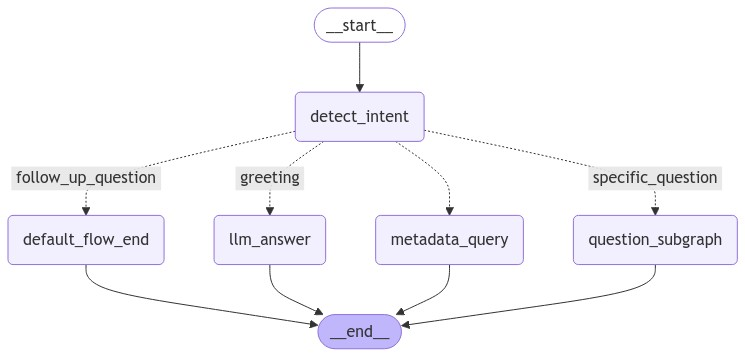

In [9]:
# Load packages from the src directory
import sys
from IPython.display import Markdown, display, Image
sys.path.append('../src')

from langchain_core.messages import HumanMessage
from vectrix_graphs import local_slm_demo

# Display the graph
display(Image(local_slm_demo.get_graph().draw_mermaid_png()))

In [10]:
#Ask the question
input = [HumanMessage(content=" ماهي إجراءات تعليق تداول الأوراق المالية المدرجة عند عدم نشر المصدر معلوماته المالية الدورية؟")]


# Run the graph
response = await local_slm_demo.ainvoke({"messages": input})
display(Markdown(f"***Question:*** \n {input[0].content}\n"))
display(Markdown(response['messages'][-1].content))

In [35]:
#Ask the question
input = [HumanMessage(content=" ماهي إجراءات تعليق تداول الأوراق المالية المدرجة بناءً على طلب المصدر؟")]


# Run the graph
response = await local_slm_demo.ainvoke({"messages": input})
display(Markdown(f"***Question:*** \n {input[0].content}\n"))
display(Markdown(response['messages'][-1].content))

***Question:*** 
  ماهي إجراءات تعليق تداول الأوراق المالية المدرجة بناءً على طلب المصدر؟


وفقاً للمصادر المقدمة، فيما يلي إجراءات تعليق تداول الأوراق المالية المدرجة بناءً على طلب المصدر:

1. تقديم الطلب:
- يجب على المصدر التقدم بطلب التعليق من خلال ممثليه المعينين أمام السوق<sup><a href="#ref1">¹</a></sup>
- يجب تقديم الطلب قبل نصف ساعة على الأقل من وقت بداية التعليق المحدد<sup><a href="#ref1">¹</a></sup>

2. محتويات الطلب:
يجب أن يتضمن الطلب المعلومات التالية<sup><a href="#ref1">¹</a></sup>:
- وقت بداية التعليق
- مدة التعليق
- مبررات طلب التعليق

3. تنفيذ التعليق:
- تقوم السوق بتنفيذ طلب التعليق فور التحقق من صحة البيانات الواردة في الطلب<sup><a href="#ref1">¹</a></sup>
- تعلن السوق عن التعليق على موقعها الإلكتروني<sup><a href="#ref1">¹</a></sup>

4. الإفصاح عن المعلومات:
- يجب على المصدر الإفصاح في أقرب وقت ممكن عن<sup><a href="#ref1">¹</a></sup>:
  * أسباب التعليق
  * المدة الزمنية المتوقعة للتعليق
  * طبيعة الحدث الذي أدى إلى التعليق
  * مدى تأثير الحدث في نشاطات المصدر

5. متابعة التعليق:
- إذا لم يتمكن المصدر من الإعلان عن الحدث خلال المدة المحددة، يجب عليه الإعلان عن سبب ذلك قبل انتهاء المدة<sup><a href="#ref3">³</a></sup>
- تقوم السوق برفع التعليق مباشرة فور انتهاء المدة المحددة في الطلب، ما لم تر الهيئة أو السوق خلاف ذلك<sup><a href="#ref3">³</a></sup>

المراجع:
1. <a id="ref1"></a>المصدر الأول: إجراءات تعليق تداول الأوراق المالية المدرجة - أولاً: تعليق تداول الأوراق المالية المدرجة بناءً على طلب المصدر
2. <a id="ref2"></a>المصدر الثاني: المحتويات والنطاق والتطبيق
3. <a id="ref3"></a>المصدر الثالث: متابعة إجراءات التعليق

In [36]:
#Ask the question
input = [HumanMessage(content="ماهي الإجراءات المتبعة عند تضمن تقرير مراجع الحسابات رأيًا معارضًا أو امتناعًا عن إبداء الرأي؟")]


# Run the graph
response = await local_slm_demo.ainvoke({"messages": input})
display(Markdown(f"***Question:*** \n {input[0].content}\n"))
display(Markdown(response['messages'][-1].content))

***Question:*** 
  ماهي الإجراءات المتبعة عند تضمن تقرير مراجع الحسابات رأيًا معارضًا أو امتناعًا عن إبداء الرأي؟


عند تضمن تقرير مراجع الحسابات رأياً معارضاً أو امتناعاً عن إبداء الرأي، تتبع الإجراءات التالية:

1. الإعلان والتعليق الأولي:
- يقوم المصدر بإعلان نتائجه المالية على موقع تداول، مع توضيح انطباق هذه الإجراءات عليه<sup><a href="#ref1">¹</a></sup>
- تقوم السوق بتعليق تداول الأوراق المالية لجلسة تداول واحدة تلي إعلان المصدر<sup><a href="#ref1">¹</a></sup>

2. فترة التصحيح الأولية:
- يستأنف التداول لمدة عشرين جلسة تداول بعد جلسة التعليق<sup><a href="#ref1">¹</a></sup>
- يجب على المصدر خلال هذه المدة الإعلان عن إزالة الرأي المعارض أو الامتناع عن إبداء الرأي<sup><a href="#ref1">¹</a></sup>

3. الإجراءات اللاحقة:
- إذا لم تتم إزالة الرأي المعارض خلال المدة المحددة، تقوم السوق بإعادة تعليق الأوراق المالية<sup><a href="#ref2">²</a></sup>
- يستمر التعليق حتى يقوم المصدر بإزالة الرأي المعارض أو الامتناع عن إبداء الرأي<sup><a href="#ref2">²</a></sup>
- يتم رفع التعليق بعد مرور جلسة تداول واحدة تلي الإعلان عن إزالة الرأي المعارض<sup><a href="#ref2">²</a></sup>

4. الإجراءات في حالة استمرار التعليق:
- إذا تجاوز التعليق شهراً واحداً، يحق للمصدر التقدم بطلب تداول أوراقه المالية خارج المنصة<sup><a href="#ref2">²</a></sup>
- في حال استمر التعليق لمدة ستة أشهر دون اتخاذ الإجراءات المناسبة للتصحيح، يجوز للهيئة إلغاء إدراج الورقة المالية للمصدر<sup><a href="#ref2">²</a></sup>

المراجع:
1. <a id="ref1"></a>المصدر الأول - الفقرة "ثالثاً: تعليق تداول الأوراق المالية المدرجة عند تضمن تقرير مراجع الحسابات رأي معارض"
2. <a id="ref2"></a>المصدر الثاني - الفقرة المتعلقة بإجراءات التعليق المستمر وإمكانية إلغاء الإدراج